In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from ls.config.loader import load_config

In [17]:
cfg = load_config("../configs/config.yaml")

In [18]:
cfg.keys()

dict_keys(['seed', 'dataset', 'audio', 'models', 'training', 'mlflow'])

In [19]:
print("Seed:", cfg.seed)
print("Dataset config:", cfg.dataset)
print("Audio config:", cfg.audio)
print("Models config:", cfg.models)
print("Training config:", cfg.training)
print("MLflow config:", cfg.mlflow)

Seed: 42
Dataset config: {'name': 'icbhi', 'data_folder': '/home/AIoT04/Datasets/icbhi_dataset', 'class_split': 'lungsound', 'split_strategy': 'official', 'test_fold': 0, 'multi_label': True, 'n_cls': 4, 'weighted_sampler': True, 'batch_size': 8, 'num_workers': 0, 'h': 128, 'w': 1024}
Audio config: {'sample_rate': 16000, 'desired_length': 10.0, 'remove_dc': False, 'normalize': False, 'pad_type': 'repeat', 'use_fade': True, 'fade_samples_ratio': 64, 'n_mels': 128, 'frame_length': 45, 'frame_shift': 10, 'low_freq': 100, 'high_freq': 8000, 'window_type': 'hanning', 'use_energy': False, 'dither': 0.0, 'mel_norm': 'mit', 'resz': 1.0, 'raw_augment': 1, 'wave_aug': [{'type': 'Crop', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'coverage': 1.0, 'p': 0.0}, {'type': 'Noise', 'color': 'white', 'p': 0.1}, {'type': 'Speed', 'factor': [0.9, 1.1], 'p': 0.1}, {'type': 'Loudness', 'factor': [0.5, 2.0], 'p': 0.1}, {'type': 'VTLP', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'fhi': 4800, 'factor': [0.9, 1

In [20]:
from ls.data.icbhi_utils import (
    get_annotations,
    get_individual_cycles
)

In [21]:
# --- 2. Load annotations ---
annotations = get_annotations(cfg.dataset.data_folder, cfg.dataset.class_split)
print(f"Found {len(annotations)} files with annotations.")

# Show one example file
first_key = next(iter(annotations.keys()))
print("Example recording:", first_key)
print(annotations[first_key].head())

Found 920 files with annotations.
Example recording: 181_1b3_Tc_mc_LittC2SE
    Start     End  Crackles  Wheezes Patient_ID Site Mode    Device  \
0   0.093   2.364         0        0        181   Tc   mc  LittC2SE   
1   2.364   8.207         0        0        181   Tc   mc  LittC2SE   
2   8.207  13.607         0        0        181   Tc   mc  LittC2SE   
3  13.607  18.836         0        0        181   Tc   mc  LittC2SE   
4  18.836  19.936         0        0        181   Tc   mc  LittC2SE   

                     File  
0  181_1b3_Tc_mc_LittC2SE  
1  181_1b3_Tc_mc_LittC2SE  
2  181_1b3_Tc_mc_LittC2SE  
3  181_1b3_Tc_mc_LittC2SE  
4  181_1b3_Tc_mc_LittC2SE  


In [22]:
# --- 3. Extract cycles for first file ---
cycles = get_individual_cycles(
    annotations[first_key],
    cfg.dataset,
    cfg.audio,
    filename=first_key,
)

/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

In [23]:
print(f"Extracted {len(cycles)} cycles from {first_key}")
cycle_id = 3
waveform, label = cycles[cycle_id]
print("Waveform shape:", waveform.shape, " Label:", label)

Extracted 5 cycles from 181_1b3_Tc_mc_LittC2SE
Waveform shape: torch.Size([1, 83664])  Label: 0


In [24]:
from ls.data.transforms import generate_fbank

In [25]:
# --- 4. Generate mel fbank features ---
fbank = generate_fbank(waveform, cfg.audio)
print("Fbank shape:", fbank.shape)

Fbank shape: torch.Size([519, 128, 1])


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

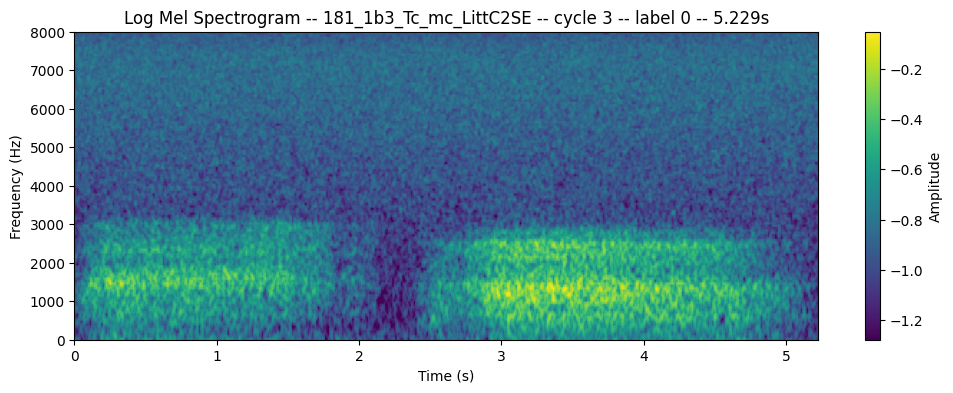

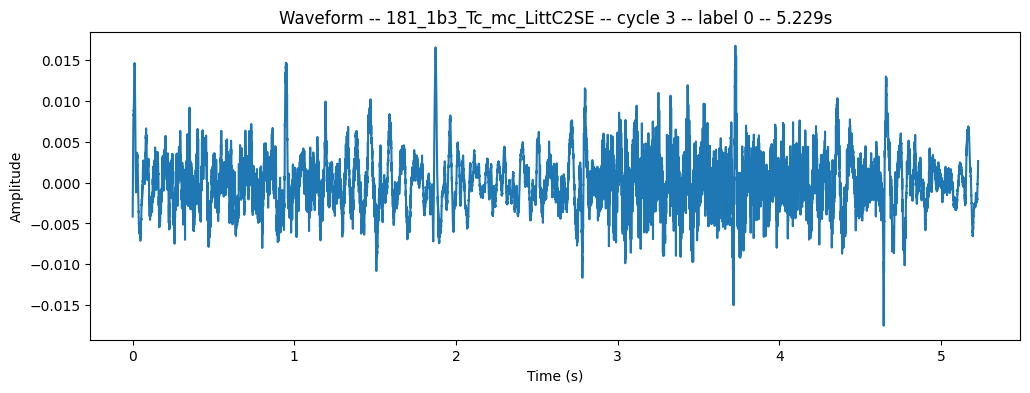

In [27]:
cycle_len = waveform.shape[1] / cfg.audio.sample_rate
x_axis = np.linspace(0, cycle_len, fbank.shape[0])
freq_axis = np.linspace(cfg.audio.low_freq, cfg.audio.high_freq, fbank.shape[1])
# orig_dur = annotations[first_key].iloc[cycle_id, 1] - annotations[first_key].iloc[cycle_id, 0]

plt.figure(figsize=(12, 4))
plt.imshow(fbank.squeeze(-1).T, aspect="auto", extent=[0, x_axis[-1], 0, freq_axis[-1]], origin="lower")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.title(f"Log Mel Spectrogram -- {first_key} -- cycle {3} -- label {label} -- {cycle_len}s")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, cycle_len, waveform.shape[1]), waveform.squeeze(0).numpy())
plt.title(f"Waveform -- {first_key} -- cycle {3} -- label {label} -- {cycle_len}s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

ipd.Audio(waveform.numpy(), rate=cfg.audio.sample_rate)

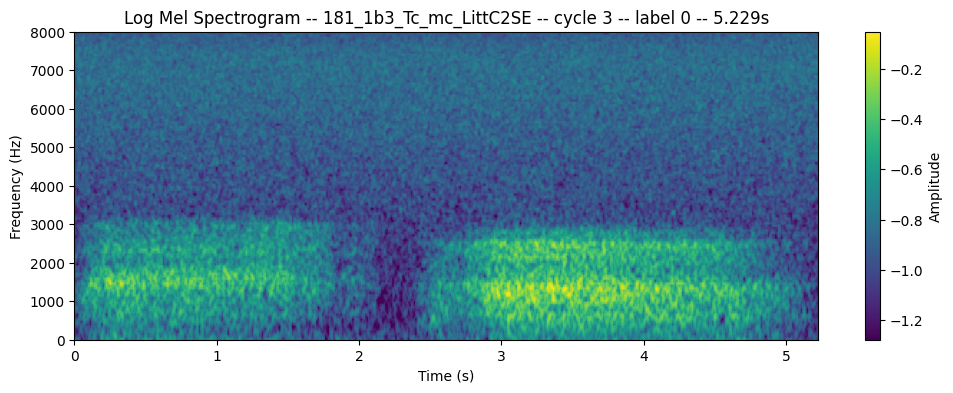

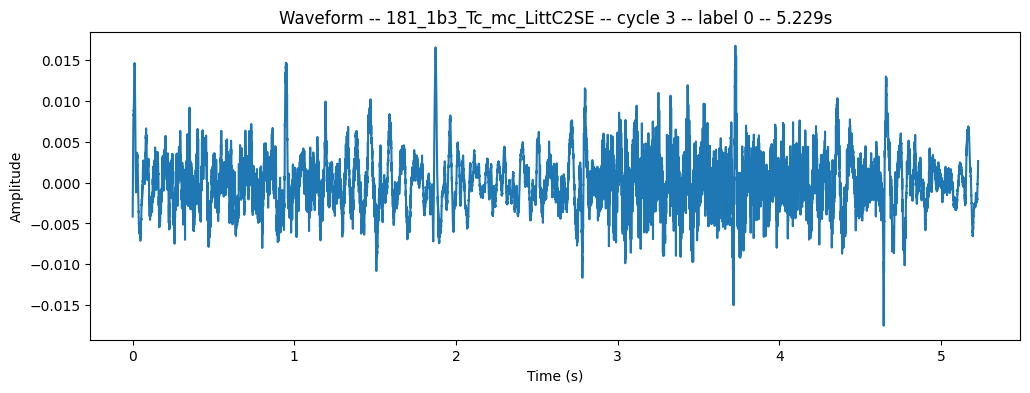

In [28]:
cycle_len = waveform.shape[1] / cfg.audio.sample_rate
x_axis = np.linspace(0, cycle_len, fbank.shape[0])
freq_axis = np.linspace(cfg.audio.low_freq, cfg.audio.high_freq, fbank.shape[1])
# orig_dur = annotations[first_key].iloc[cycle_id, 1] - annotations[first_key].iloc[cycle_id, 0]

plt.figure(figsize=(12, 4))
plt.imshow(fbank.squeeze(-1).T, aspect="auto", extent=[0, x_axis[-1], 0, freq_axis[-1]], origin="lower")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.title(f"Log Mel Spectrogram -- {first_key} -- cycle {3} -- label {label} -- {cycle_len}s")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, cycle_len, waveform.shape[1]), waveform.squeeze(0).numpy())
plt.title(f"Waveform -- {first_key} -- cycle {3} -- label {label} -- {cycle_len}s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

ipd.Audio(waveform.numpy(), rate=cfg.audio.sample_rate)